In [26]:
#pip install pandas numpy scikit-learn matplotlib jupyter

# DAMO-640-10 · Fall 2025  
## Assignment 1 — Supervised Learning (Haberman's Survival)

**Author:** Fabio dos Santos Prumucena - NF1002000 
**Dataset:** Haberman's Survival (UCI)  
**Deadline:** November 2, 2025, 11:59 PM

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, roc_auc_score
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_curve, roc_auc_score, classification_report
)

## Data Loading & EDA

In [28]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/haberman/haberman.data"
cols = ["age", "operation_year", "axillary_nodes", "survival_status"]
df = pd.read_csv(url, header=None, names=cols)

In [ ]:
print("First 5 rows of the dataset:")
print(df.head())
print("\nDataset statistical summary:")
print(df.describe())
print("\nSurvival status distribution:")
print(df['survival_status'].value_counts())
print("\nMissing values check:")
print(df.isna().sum())

age                0
operation_year     0
axillary_nodes     0
survival_status    0
dtype: int64

In [ ]:
print("Dataset information:")
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306 entries, 0 to 305
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype
---  ------           --------------  -----
 0   age              306 non-null    int64
 1   operation_year   306 non-null    int64
 2   axillary_nodes   306 non-null    int64
 3   survival_status  306 non-null    int64
dtypes: int64(4)
memory usage: 9.7 KB


### Invalid Years and Nodes

In [ ]:
print("Records with invalid operation years (outside 1958-1969):")
print(df[~df['operation_year'].between(1958, 1969)])
print("\nRecords with negative axillary nodes:")
print(df[df['axillary_nodes'] < 0])

     age  operation_year  axillary_nodes  survival_status
0     30              64               1                1
1     30              62               3                1
2     30              65               0                1
3     31              59               2                1
4     31              65               4                1
..   ...             ...             ...              ...
301   75              62               1                1
302   76              67               0                1
303   77              65               3                1
304   78              65               1                2
305   83              58               2                2

[306 rows x 4 columns]
Empty DataFrame
Columns: [age, operation_year, axillary_nodes, survival_status]
Index: []


In [ ]:
# 1️⃣ Convert survival_status to binary
# In the original dataset: 1 = survived ≥5 years, 2 = died <5 years
df['label'] = df['survival_status'].map({1: 1, 2: 0})
print("Binary label conversion completed.")
print("Label distribution:")
print(df['label'].value_counts().sort_index())

In [ ]:
# 2️⃣ Separate features (X) and label (y)
X = df[['age', 'operation_year', 'axillary_nodes']].copy()
y = df['label'].copy()
print("Features (X) and labels (y) separated successfully.")
print(f"Features shape: {X.shape}")
print(f"Labels shape: {y.shape}")

In [ ]:
# 3️⃣ Split into train and test (75/25)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, stratify=y, random_state=42
) 
print(f"Train: {X_train.shape}, Test: {X_test.shape}")

Treino: (229, 3), Teste: (77, 3)


In [ ]:
# 4️⃣ Standardize numerical features
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.transform(X_test)
print("Feature standardization completed.")
print(f"Training set mean: {X_train_std.mean(axis=0).round(4)}")
print(f"Training set std: {X_train_std.std(axis=0).round(4)}")

In [ ]:
# Optional: show before/after to check standardization
print("\nBefore standardization (example):")
display(X_train.head())

print("\nAfter standardization (first 5 rows):")
print(pd.DataFrame(X_train_std, columns=X.columns).head())


Antes da padronização (exemplo):


,age,operation_year,axillary_nodes
15,35,63,0
207,57,67,0
14,35,64,13
126,50,59,0
86,45,64,0



Depois da padronização (primeiras 5 linhas):
        age  operation_year  axillary_nodes
0 -1.642926        0.072022       -0.559195
1  0.426339        1.316785       -0.559195
2 -1.642926        0.383213        1.129166
3 -0.232063       -1.172741       -0.559195
4 -0.702351        0.383213       -0.559195


## PCA (Dimensionality Reduction)

In [ ]:
# 1️⃣ Fit PCA on standardized training set
pca_probe = PCA().fit(X_train_std)
print("PCA fitted on standardized training data.")

In [ ]:
# 2️⃣ Calculate cumulative variance
cum_var = np.cumsum(pca_probe.explained_variance_ratio_)
print("Cumulative variance calculated.")

In [ ]:
# 3️⃣ Determine minimum number of components with >= 90% variance
n_components_90 = int(np.argmax(cum_var >= 0.90) + 1)
print("Explained variance per component:", pca_probe.explained_variance_ratio_)
print("Cumulative variance:", cum_var)
print(f"→ Number of components needed for ≥90% variance: {n_components_90}")

Variância explicada por componente: [0.37298962 0.32305988 0.3039505 ]
Variância acumulada: [0.37298962 0.6960495  1.        ]
--> Número de componentes necessários para >=90% da variância: 3


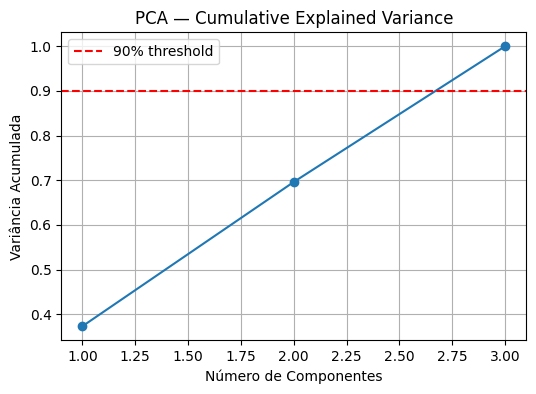

In [ ]:
# 4️⃣ Plot cumulative variance
plt.figure(figsize=(6,4))
plt.plot(range(1, len(cum_var)+1), cum_var, marker='o')
plt.axhline(0.90, color='r', linestyle='--', label='90% threshold')
plt.title("PCA — Cumulative Explained Variance")
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Variance")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# 5️⃣ Apply PCA with chosen number of components
pca = PCA(n_components=n_components_90, random_state=42)
X_train_pca = pca.fit_transform(X_train_std)
X_test_pca = pca.transform(X_test_std)

print("Shape of transformed data:")
print("Train:", X_train_pca.shape)
print("Test:", X_test_pca.shape)

Forma dos dados transformados:
Treino: (229, 3)
Teste: (77, 3)


## Supervised Learning

In [ ]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
print("Cross-validation strategy initialized: 5-fold stratified with shuffling.")

In [ ]:
# -------------------------------------------------------------------
# 1️⃣ Logistic Regression — test two values of C
# -------------------------------------------------------------------
print("Testing Logistic Regression with different C values...")
lr_results = []
for C in [0.1, 1.0]:
    lr = LogisticRegression(C=C, random_state=42, max_iter=200)
    scores = cross_val_score(lr, X_train_pca, y_train, cv=cv, scoring="accuracy")
    lr_results.append({
        "Model": "LogisticRegression",
        "C": C,
        "Mean_CV_Accuracy": scores.mean(),
        "Std": scores.std()
    })

lr_df = pd.DataFrame(lr_results)
print("Logistic Regression cross-validation results:")
display(lr_df)

,Model,C,Mean_CV_Accuracy,Std
0,LogisticRegression,0.1,0.720580,0.036931
1,LogisticRegression,1.0,0.742415,0.024704


In [ ]:
# Choose the best C value
best_lr_row = lr_df.iloc[lr_df["Mean_CV_Accuracy"].idxmax()]
best_lr_C = best_lr_row["C"]
print(f"✅ Best C for Logistic Regression: {best_lr_C}")

 Melhor C para Logistic Regression: 1.0


In [ ]:
# -------------------------------------------------------------------
# 2️⃣ Decision Tree — test two values of max_depth
# -------------------------------------------------------------------
print("Testing Decision Tree with different max_depth values...")
dt_results = []
for depth in [3, None]:
    dt = DecisionTreeClassifier(max_depth=depth, random_state=42)
    scores = cross_val_score(dt, X_train_pca, y_train, cv=cv, scoring="accuracy")
    dt_results.append({
        "Model": "DecisionTree",
        "max_depth": "None" if depth is None else depth,
        "Mean_CV_Accuracy": scores.mean(),
        "Std": scores.std()
    })

dt_df = pd.DataFrame(dt_results)
print("Decision Tree cross-validation results:")
display(dt_df)

,Model,max_depth,Mean_CV_Accuracy,Std
0,DecisionTree,3,0.707826,0.074974
1,DecisionTree,None,0.611594,0.069444


In [ ]:
# Choose the best max_depth
best_dt_row = dt_df.iloc[dt_df["Mean_CV_Accuracy"].idxmax()]
best_dt_depth = None if best_dt_row["max_depth"] == "None" else int(best_dt_row["max_depth"])
print(f"✅ Best max_depth for Decision Tree: {best_dt_depth}")

-> Melhor max_depth para Decision Tree: 3


### ROC/AUC Evaluation

In [ ]:
# 1) Train with best hyperparameters (from CV)
print("Training models with optimal hyperparameters...")

best_lr = LogisticRegression(C=best_lr_C, random_state=42, max_iter=200)
best_lr.fit(X_train_pca, y_train)
lr_proba = best_lr.predict_proba(X_test_pca)[:, 1]
lr_pred  = (lr_proba >= 0.5).astype(int)

best_dt = DecisionTreeClassifier(max_depth=best_dt_depth, random_state=42)
best_dt.fit(X_train_pca, y_train)
dt_proba = best_dt.predict_proba(X_test_pca)[:, 1]
dt_pred  = (dt_proba >= 0.5).astype(int)

print("Model training completed.")

In [ ]:
# 2) Utility function for metrics
def metrics_dict(y_true, y_pred, y_proba):
    return {
        "accuracy":  accuracy_score(y_true, y_pred),
        "precision": precision_score(y_true, y_pred, zero_division=0),
        "recall":    recall_score(y_true, y_pred, zero_division=0),
        "f1":        f1_score(y_true, y_pred, zero_division=0),
        "auc":       roc_auc_score(y_true, y_proba),
    }

lr_metrics = metrics_dict(y_test, lr_pred, lr_proba)
dt_metrics = metrics_dict(y_test, dt_pred, dt_proba)

# 3) Comparative table
metrics_df = pd.DataFrame([
    {"model": "LogisticRegression", **lr_metrics},
    {"model": "DecisionTree",       **dt_metrics},
])
print("Model Performance Comparison:")
display(metrics_df)

,model,accuracy,precision,recall,f1,auc
0,LogisticRegression,0.740260,0.746667,0.982456,0.848485,0.742544
1,DecisionTree,0.701299,0.742857,0.912281,0.818898,0.525877


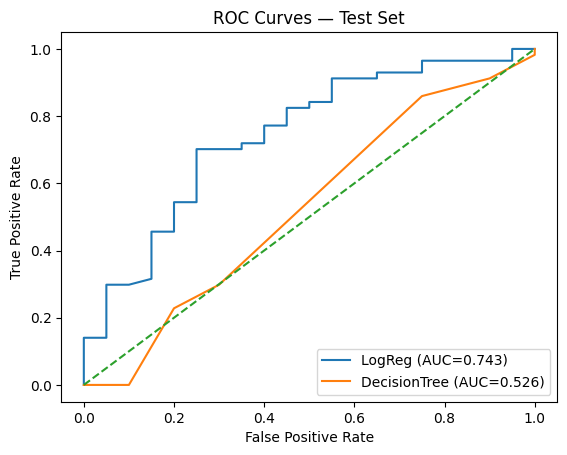

In [ ]:
# 4) ROC curves on the same plot
print("Generating ROC curve comparison...")

lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_proba)
dt_fpr, dt_tpr, _ = roc_curve(y_test, dt_proba)

plt.figure(figsize=(8, 6))
plt.plot(lr_fpr, lr_tpr, label=f"Logistic Regression (AUC={lr_metrics['auc']:.3f})")
plt.plot(dt_fpr, dt_tpr, label=f"Decision Tree (AUC={dt_metrics['auc']:.3f})")
plt.plot([0, 1], [0, 1], "--", color='gray', label='Random Classifier')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves Comparison — Test Set")
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.show()

In [ ]:
# 5) Classification reports (details per class)
print("\nClassification report — Logistic Regression")
print(classification_report(y_test, lr_pred, digits=4, zero_division=0))

print("\nClassification report — Decision Tree")
print(classification_report(y_test, dt_pred, digits=4, zero_division=0))


Classification report — Logistic Regression
              precision    recall  f1-score   support

           0     0.5000    0.0500    0.0909        20
           1     0.7467    0.9825    0.8485        57

    accuracy                         0.7403        77
   macro avg     0.6233    0.5162    0.4697        77
weighted avg     0.6826    0.7403    0.6517        77


Classification report — Decision Tree
              precision    recall  f1-score   support

           0     0.2857    0.1000    0.1481        20
           1     0.7429    0.9123    0.8189        57

    accuracy                         0.7013        77
   macro avg     0.5143    0.5061    0.4835        77
weighted avg     0.6241    0.7013    0.6447        77

